# Figure 1 candidates

Here we want to show the relationship between our main variables. On one end, we want to explain the relationship of our treatments with the outcomes, this is showing how $\Delta$ NBR and FRP relates to CBI, but also how these relate to each other and with emissions from the inventories. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from prescribed.plot import template_plots

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

### Now all the things together!

In [3]:
ca_geom = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("EPSG:3310")


mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

In [9]:
# Intensity
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp_nominal_conf/frp_concat.feather"
)

# Severity
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]],
    left_on="event_id",
    right_on="Event_ID",
    how="left",
)
dnbr["dnbr"] = np.where(dnbr["dnbr"] < 0, 0, dnbr["dnbr"])

dnbr["prescribed"] = (
    dnbr["event_id"]
    .isin(mtbs_ca[mtbs_ca.Incid_Type == "Prescribed Fire"].Event_ID.tolist())
    .astype(np.int8)
)

# Emissions FINN
emissions_all = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/emissions_finn/finn_GEOSCHEM_mean.feather"
)
emissions_all["year"] = emissions_all["time"].dt.year
emissions_all["PM25"] = emissions_all["PM25"] * 0.001  # Convert to Tons

In [10]:
from prescribed.plot import data_fire_plot

event_id = "CA3966012280920200817"
fire = data_fire_plot(
    frp=frp,
    dnbr=dnbr,
    wide_treats="/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather",
    emissions=emissions_all,
    mtbs=mtbs_ca,
    year=2020,
    event_id=event_id,
)

fires = data_fire_plot(
    frp=frp,
    dnbr=dnbr,
    wide_treats="/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather",
    emissions=emissions_all,
    mtbs=mtbs_ca,
)

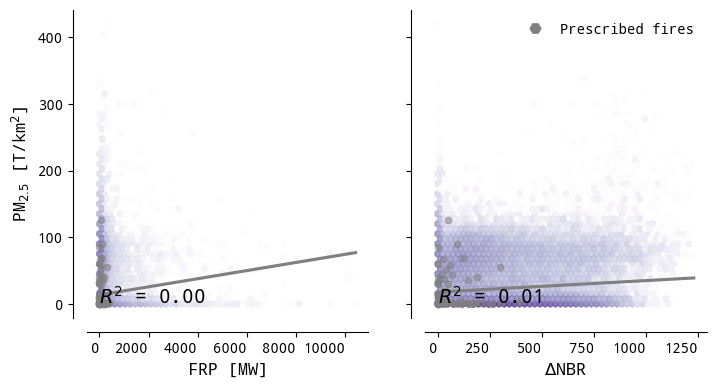

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

fires.plot.hexbin(
    "frp",
    "PM25",
    ax=ax[0],
    alpha=0.8,
    gridsize=50,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax[0],
    alpha=0.5,
    color="gray",
)

# Add regression line w/ seaborn
sns.regplot(
    x="frp",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax[0],
    ci=True,
    robust=False,
)
# Run regression to get R^2
model = smf.ols("PM25 ~ frp + fire", data=fires).fit()
r2 = model.rsquared
ax[0].text(
    0.05,
    0.95,
    f"$R^2$ = {r2:.2f}",
)
template_plots(ax[0], xlab="FRP [MW]", ylab=r"PM$_{2.5}$ [T/km$^2$]")

fires.plot.hexbin(
    "dnbr",
    "PM25",
    ax=ax[1],
    alpha=0.8,
    gridsize=50,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax[1],
    alpha=0.5,
    color="gray",
)

# Add regression line w/ seaborn
sns.regplot(
    x="dnbr",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax[1],
    ci=True,
    robust=False,
)
# Run regression to get R^2
model = smf.ols("PM25 ~ dnbr + fire", data=fires).fit()
r2 = model.rsquared
ax[1].text(
    0.05,
    0.95,
    f"$R^2$ = {r2:.2f}",
)
template_plots(ax[1], ylab="PM2.5", xlab=r"$\Delta$NBR")

# Add a legend with a single red hexagon for the treatment
ax[1].legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="H",
            color="w",
            markerfacecolor="gray",
            markersize=10,
        ),
    ],
    ["Prescribed fires"],
    fontsize=10,
    frameon=False,
)

In [16]:
import pyfixest as pf

pf.feols("PM25 ~ frp | grid_id + year", data=fires).summary()

###

Estimation:  OLS
Dep. var.: PM25, Fixed effects: grid_id+year
Inference:  CRV1
Observations:  113733

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| frp           |      0.007 |        0.001 |     7.019 |      0.000 |  0.005 |   0.009 |
---
RMSE: 7.91 R2: 0.924 R2 Within: 0.006 


In [17]:
pf.feols("PM25 ~ dnbr | grid_id + year", data=fires).summary()

###

Estimation:  OLS
Dep. var.: PM25, Fixed effects: grid_id+year
Inference:  CRV1
Observations:  59534

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| dnbr          |      0.010 |        0.002 |     5.621 |      0.000 |  0.007 |   0.014 |
---
RMSE: 5.878 R2: 0.971 R2 Within: 0.01 


In [19]:
pf.feols("dnbr ~ frp | grid_id + year", data=fires[fires.frp < 100]).summary()

###

Estimation:  OLS
Dep. var.: dnbr, Fixed effects: grid_id+year
Inference:  CRV1
Observations:  148382

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| frp           |      3.180 |        0.047 |    67.577 |      0.000 |  3.088 |   3.272 |
---
RMSE: 88.12 R2: 0.794 R2 Within: 0.138 


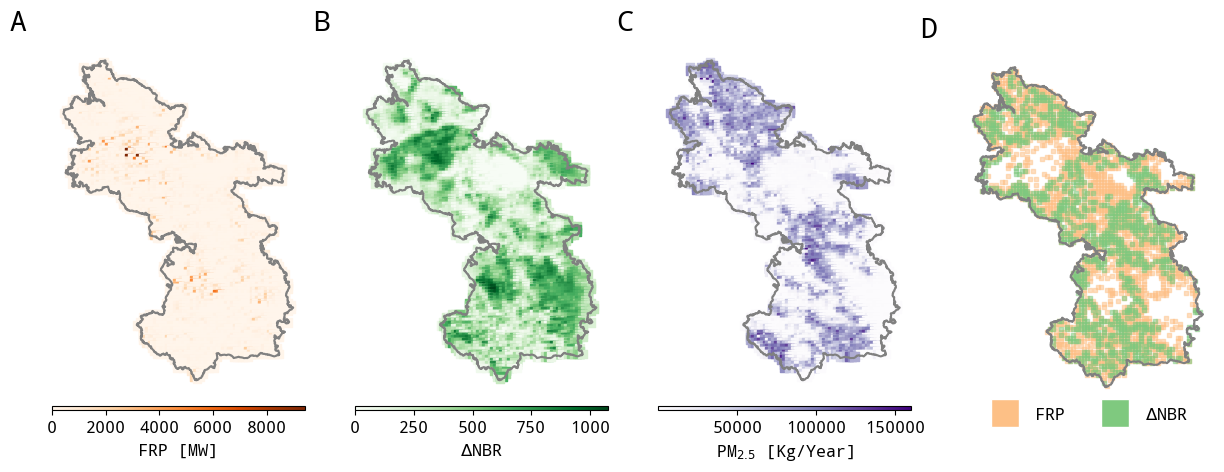

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Take care of the colorbar size
fig, ax = plt.subplots(1, 4, figsize=(15, 10))


divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[0], color="Grey")

# Plot with divergent color scheme
ax[0] = fire.plot(
    column="frp",
    legend=True,
    cmap="Oranges",
    marker=",",
    ax=ax[0],
    cax=cax,
    legend_kwds={"label": "FRP [MW]", "orientation": "horizontal"},
)

template_plots(ax[0], xlab="", ylab="", label="A", no_axis=True)


# Take care of the colorbar size
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)


mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[1], color="Grey")

# Plot with divergent color scheme
fire.plot(
    column="dnbr",
    legend=True,
    cmap="Greens",
    ax=ax[1],
    marker=",",
    cax=cax,
    legend_kwds={"label": r"$\Delta$NBR", "orientation": "horizontal"},
)
template_plots(ax[1], xlab="", ylab="", label="B", no_axis=True)


# Plot emissions
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[2], color="Grey")

# Plot with divergent color scheme
ax[2] = fire.plot(
    column="PM25",
    legend=True,
    cmap="Purples",
    ax=ax[2],
    marker=",",
    cax=cax,
    legend_kwds={"label": r"PM$_{2.5}$ [Kg/Year]", "orientation": "horizontal"},
)
template_plots(ax[2], xlab="", ylab="", label="C", no_axis=True)

# Plot emissions
mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[3], color="Grey")

# Plot with divergent color scheme
fire[fire.treat_intensity == 1].plot(
    marker=",", legend=False, ax=ax[3], color="#fdc086", alpha=0.5, markersize=8
)
# Plot with divergent color scheme
fire[fire.treat_severity == 1].plot(
    marker=",", legend=False, ax=ax[3], color="#7fc97f", alpha=0.5, markersize=8
)

template_plots(ax[3], xlab="", ylab="", label="D", no_axis=True)

ax[3].legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="s",
            color="w",
            markerfacecolor="#fdc086",
            markersize=20,
        ),
        plt.Line2D(
            [1],
            [10],
            marker="s",
            color="w",
            markerfacecolor="#7fc97f",
            markersize=20,
        ),
    ],
    ["FRP", r"$\Delta$NBR"],
    fontsize=12,
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

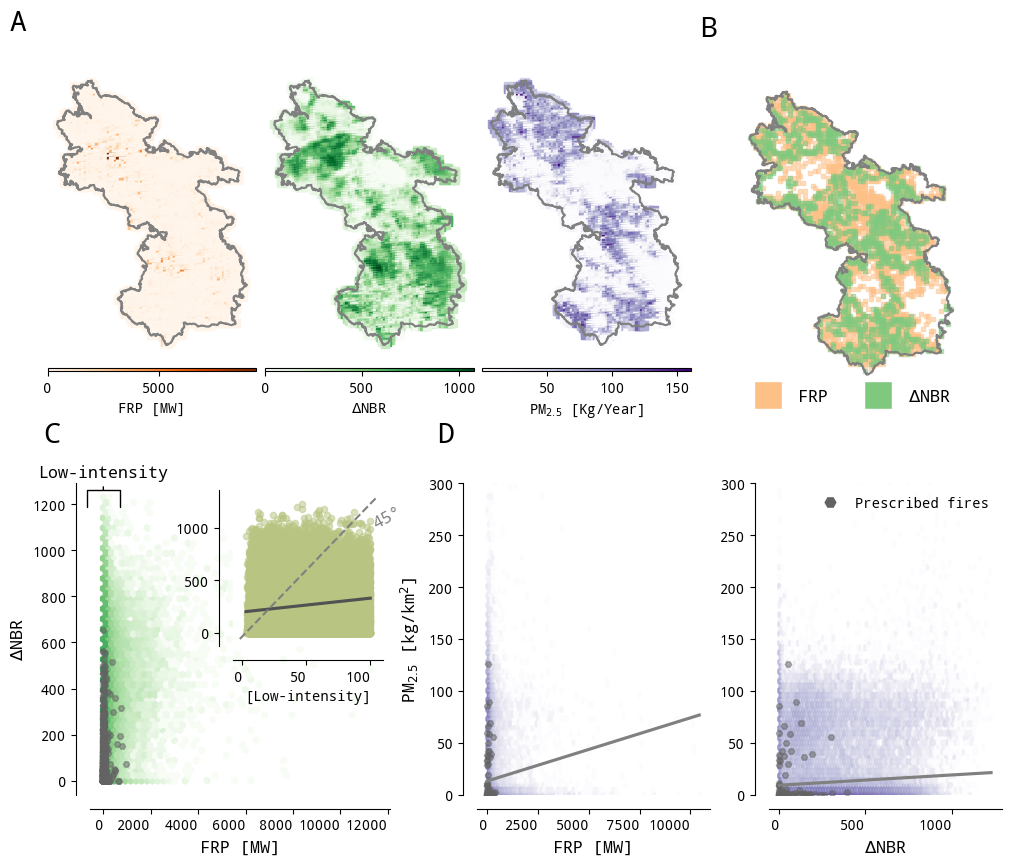

In [12]:
from matplotlib.gridspec import GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set the font size to be 12
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize=(10, 8.5), layout="compressed")
spec = fig.add_gridspec(2, 3)

################################################################################
############################# PLOT FIRE DYNAMICS MAPS ##########################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 3, subplot_spec=spec[0, 0:-1])

# Plot FRP
ax = fig.add_subplot(subspec[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="frp",
    legend=True,
    cmap="Oranges",
    marker=",",
    ax=ax,
    cax=cax,
    legend_kwds={"label": "FRP [MW]", "orientation": "horizontal"},
)

template_plots(ax, xlab="", ylab="", label="A", no_axis=True)

# Plot dNBR
ax = fig.add_subplot(subspec[0, 1])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="dnbr",
    legend=True,
    cmap="Greens",
    ax=ax,
    marker=",",
    cax=cax,
    legend_kwds={"label": r"$\Delta$NBR", "orientation": "horizontal"},
)
template_plots(ax, xlab="", ylab="", no_axis=True)

# Plot emissions
ax = fig.add_subplot(subspec[0, 2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="PM25",
    legend=True,
    cmap="Purples",
    ax=ax,
    marker=",",
    cax=cax,
    legend_kwds={"label": r"PM$_{2.5}$ [Kg/Year]", "orientation": "horizontal"},
)
template_plots(ax, xlab="", ylab="", no_axis=True)

# Plot treatments
ax = fig.add_subplot(spec[0, 2])

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")

# Plot with divergent color scheme
fire[fire.treat_intensity == 1].plot(
    marker=",", legend=False, ax=ax, color="#fdc086", alpha=0.5, markersize=8
)
# Plot with divergent color scheme
fire[fire.treat_severity == 1].plot(
    marker=",", legend=False, ax=ax, color="#7fc97f", alpha=0.5, markersize=8
)

template_plots(ax, xlab="", ylab="", label="B", no_axis=True)

ax.legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="s",
            color="w",
            markerfacecolor="#fdc086",
            markersize=20,
        ),
        plt.Line2D(
            [1],
            [10],
            marker="s",
            color="w",
            markerfacecolor="#7fc97f",
            markersize=20,
        ),
    ],
    ["FRP", r"$\Delta$NBR"],
    fontsize=12,
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

################################################################################
########################### DNBR and FRP relationship ##########################
################################################################################

ax = fig.add_subplot(spec[1, 0])

# Create an inset plot to the main plot located to the top right
axins = inset_axes(ax, width="50%", height="50%", loc=1)

# Transform the data to plot a 2-d hexbin using matplotlib
fires.plot.hexbin(
    x="frp",
    y="dnbr",
    cmap="Greens",
    ax=ax,
    gridsize=50,
    bins="log",
    colorbar=False,
)

# Plot the prescribed fires in gray
fires[(fires["prescribed"] == 1)].plot.scatter(
    x="frp",
    y="dnbr",
    c="#636363",
    ax=ax,
    alpha=0.5,
    colorbar=False,
    fontsize=10,
    marker="H",
)

template_plots(ax, xlab="FRP [MW]", ylab=r"$\Delta$NBR", label="C")


# Insert an annotation with an arrowprop
ax.annotate(
    "Low-intensity",
    xy=(0, 1250),
    xytext=(0, 1300),
    ha="center",
    va="bottom",
    fontsize=12,
    arrowprops=dict(arrowstyle="-[, widthB=1.0, lengthB=1.0", lw=1, color="k"),
)

# Inlet plot
plt.rcParams.update({"font.size": 14})
fires[fires["treat_intensity"] == 1].plot.scatter(
    x="frp",
    y="dnbr",
    c="#B8C582",
    ax=axins,
    alpha=0.5,
    colorbar=False,
    fontsize=10,
)

sns.regplot(
    x="frp",
    y="dnbr",
    data=fires[fires["treat_intensity"] == 1],
    scatter=False,
    ax=axins,
    color="#525252",
    robust=False,
)
template_plots(axins, xlab="", ylab="", diag=True)

# Add text in the same color over the 45-degree.
axins.text(100, 1000, "45°", rotation=28, color="gray", fontsize=12)
axins.set_title("[Low-intensity]", fontsize=10, y=-0.4)


################################################################################
####################### EMISSIONS AND INTENSITY/SEVERITY #######################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[1, 1:3])
ax = fig.add_subplot(subspec[0, 0])

# ax = fig.add_subplot(spec[1, 1])

fires.plot.hexbin(
    "frp",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)
# Set y-axis limit to 1000
ax.set_ylim(0, 300)

# Color hex in gray if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    marker="H",
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="frp",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=False,
)
template_plots(ax, xlab="FRP [MW]", ylab=r"PM$_{2.5}$ [kg/km$^2$]", label="D")

ax = fig.add_subplot(subspec[0, 1], sharey=ax)
# ax = fig.add_subplot(spec[1, 2])

fires.plot.hexbin(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Set y-axis limit to 1000
ax.set_ylim(0, 300)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    marker="H",
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="dnbr",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=True,
)

template_plots(ax, ylab="", xlab=r"$\Delta$NBR")

# Add a legend with a single red hexagon for the treatment
ax.legend(
    [
        plt.Line2D(
            [1],
            [0],
            marker="H",
            color="w",
            markerfacecolor="#636363",
            markersize=10,
        ),
    ],
    ["Prescribed fires"],
    fontsize=10,
    frameon=False,
)
plt.savefig("../figs/potential_fig1.png", bbox_inches="tight", dpi=300)